In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import time
warnings.filterwarnings("ignore")

/Users/benmagevney/miniconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/benmagevney/miniconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# read datasets 
enc = pd.read_csv('../data/regional_datasets/xgboost/enc_data_multi.csv')
esc = pd.read_csv('../data/regional_datasets/xgboost/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../data/regional_datasets/xgboost/mountain_data_multi.csv')
new_england = pd.read_csv('../data/regional_datasets/xgboost/new_england_data_multi.csv')
pacific = pd.read_csv('../data/regional_datasets/xgboost/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../data/regional_datasets/xgboost/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../data/regional_datasets/xgboost/wnc_data_multi.csv')
wsc = pd.read_csv('../data/regional_datasets/xgboost/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)


In [80]:
params = {
    "East North Central": {
        "features": ['7_day_shift',
                    'location_key_US_OH',
                    'stay_at_home_requirements',
                    'income_support',
                    '7_day_avg',
                    'new_deceased',
                    'facial_coverings',
                    'international_travel_controls',
                    'month',
                    'location_key_US_IN',
                    'new_persons_vaccinated',
                    'location_key_US_MI',
                    'weekofyear',
                    'cumulative_deceased',
                    'cumulative_confirmed',
                    'cumulative_hospitalized_patients',
                    'workplace_closing',
                    'stringency_index',
                    'new_hospitalized_patients',
                    '1_day_shift',
                    'restrictions_on_gatherings',
                    'new_vaccine_doses_administered',
                    'cumulative_persons_vaccinated'],
    }
}

In [134]:
def train_baseline_model(df, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    df.sort_values('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train.drop(columns=['new_confirmed', 'date', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    y_train_log = np.log(y_train)
    y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test.drop(columns=['new_confirmed', 'date', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
    model.fit(X_train, y_train_log)

    # make predictions
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(test['date'], y_test, label='Actual')
        plt.plot(test['date'], y_pred, label='Predicted')
        plt.legend() 
        plt.show()

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    print(f"Important features: {list(important_features.index)}")


In [135]:
start_time = time.time()
for df in datasets:
    train_baseline_model(df, plot=False)
    print("\n")
    
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 1765.79
MSE: 15427190.22
RMSE: 3927.75
MASE: 0.76
Number of features for 95.0% importance: 23, out of 62
Important features: ['7_day_shift', 'location_key_US_OH', 'stay_at_home_requirements', 'income_support', '7_day_avg', 'new_deceased', 'facial_coverings', 'international_travel_controls', 'month', 'location_key_US_IN', 'new_persons_vaccinated', 'location_key_US_MI', 'weekofyear', 'cumulative_deceased', 'cumulative_confirmed', 'cumulative_hospitalized_patients', 'workplace_closing', 'stringency_index', 'new_hospitalized_patients', '1_day_shift', 'restrictions_on_gatherings', 'new_vaccine_doses_administered', 'cumulative_persons_vaccinated']


Training model for East South Central...
MAE: 887.28
MSE: 4154917.66
RMSE: 2038.36
MASE: 0.65
Number of features for 95.0% importance: 35, out of 62
Important features: ['new_deceased', 'international_travel_controls', '7_day_avg', 'cumulative_vaccine_doses_administered_moderna', 'location_key_US_AL',

## Feature Selection

In [137]:
baseline_fs = {
    "East North Central": {
        "features": ['7_day_shift',
                    'location_key_US_OH',
                    'stay_at_home_requirements',
                    'income_support',
                    '7_day_avg',
                    'new_deceased',
                    'facial_coverings',
                    'international_travel_controls',
                    'month',
                    'location_key_US_IN',
                    'new_persons_vaccinated',
                    'location_key_US_MI',
                    'weekofyear',
                    'cumulative_deceased',
                    'cumulative_confirmed',
                    'cumulative_hospitalized_patients',
                    'workplace_closing',
                    'stringency_index',
                    'new_hospitalized_patients',
                    '1_day_shift',
                    'restrictions_on_gatherings',
                    'new_vaccine_doses_administered',
                    'cumulative_persons_vaccinated'],
    },
    "East South Central": {
        "features": ['new_deceased', 'international_travel_controls', '7_day_avg', 'cumulative_vaccine_doses_administered_moderna', 'location_key_US_AL', '7_day_shift', 'cumulative_persons_vaccinated', 'public_transport_closing', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_persons_fully_vaccinated_janssen', 'stringency_index', 'cumulative_hospitalized_patients', 'dayofyear', '1_day_shift', 'cumulative_persons_fully_vaccinated_moderna', 'location_key_US_KY', 'weekofyear', 'new_persons_fully_vaccinated_janssen', 'stay_at_home_requirements', 'average_temperature_celsius', 'school_closing', 'maximum_temperature_celsius', 'debt_relief', 'new_hospitalized_patients', 'cancel_public_events', 'current_hospitalized_patients', 'relative_humidity', 'income_support', '2_day_shift', 'day', 'new_vaccine_doses_administered_pfizer', 'cumulative_confirmed', 'workplace_closing', 'new_persons_fully_vaccinated_moderna', 'new_persons_vaccinated']
    },
    "Mid-Atlantic": {
        "features": ['7_day_avg', 'cumulative_confirmed', '1_day_shift', 'new_persons_vaccinated', 'international_travel_controls', '2_day_shift', 'relative_humidity', 'new_deceased', '8_day_shift', 'income_support', 'new_vaccine_doses_administered_moderna', 'dayofyear', 'current_hospitalized_patients', 'maximum_temperature_celsius', 'month', '9_day_shift', 'weekofyear'],
    },
    "Mountain": {
        "features": ['7_day_shift', 'location_key_US_AZ', '7_day_avg', 'location_key_US_NM', 'income_support', 'cumulative_vaccine_doses_administered_janssen', 'new_deceased', 'year', 'contact_tracing', 'location_key_US_CO', 'international_travel_controls', 'debt_relief', 'cancel_public_events', 'weekofyear', 'cumulative_persons_fully_vaccinated', '1_day_shift', 'cumulative_persons_fully_vaccinated_moderna', 'new_persons_fully_vaccinated_janssen', 'cumulative_hospitalized_patients', 'cumulative_persons_fully_vaccinated_pfizer', 'dayofyear', 'cumulative_persons_vaccinated', 'new_persons_vaccinated', 'stringency_index', 'public_transport_closing', 'month', 'stay_at_home_requirements', 'cumulative_deceased', 'location_key_US_WY', 'location_key_US_ID', 'cumulative_confirmed', 'vaccination_policy', '6_day_shift', 'restrictions_on_internal_movement', 'cumulative_vaccine_doses_administered_moderna', 'day', 'new_vaccine_doses_administered_pfizer'],
    },
    "New England": {
        "features": ['7_day_shift', '7_day_avg', 'cancel_public_events', 'public_transport_closing', 'new_deceased', 'international_travel_controls', 'new_persons_fully_vaccinated_moderna', 'cumulative_vaccine_doses_administered_pfizer', 'new_vaccine_doses_administered_janssen', 'facial_coverings', 'vaccination_policy', 'weekofyear', 'cumulative_persons_fully_vaccinated_moderna', 'location_key_US_VT', 'new_persons_vaccinated', 'new_persons_fully_vaccinated_janssen', 'cumulative_vaccine_doses_administered_janssen', 'new_persons_fully_vaccinated', 'restrictions_on_internal_movement', 'current_hospitalized_patients', '1_day_shift', 'cumulative_persons_fully_vaccinated', 'dayofyear', 'location_key_US_CT', 'cumulative_deceased', 'testing_policy', 'cumulative_persons_fully_vaccinated_pfizer', 'income_support', 'cumulative_vaccine_doses_administered', 'cumulative_persons_vaccinated', 'stringency_index', 'new_persons_fully_vaccinated_pfizer', 'school_closing', 'cumulative_confirmed', 'cumulative_hospitalized_patients', 'new_hospitalized_patients', 'public_information_campaigns', 'cumulative_vaccine_doses_administered_moderna', 'cumulative_persons_fully_vaccinated_janssen', 'rainfall_mm'],
    },
    "Pacific": {
        "features": ['7_day_shift', '7_day_avg', 'workplace_closing', 'cancel_public_events', 'cumulative_persons_fully_vaccinated_moderna', 'restrictions_on_gatherings', 'weekofyear', 'stringency_index', 'new_deceased', 'cumulative_persons_fully_vaccinated_janssen', 'new_vaccine_doses_administered', '10_day_shift', '1_day_shift', '3_day_shift', 'school_closing', 'year', 'stay_at_home_requirements', 'cumulative_confirmed', 'cumulative_hospitalized_patients', 'cumulative_deceased', 'new_hospitalized_patients', 'cumulative_vaccine_doses_administered_janssen', 'new_persons_vaccinated', 'cumulative_persons_vaccinated', 'facial_coverings', 'dayofyear', 'month'],
    },
    "South Atlantic": {
        "features": ['7_day_shift', '7_day_avg', 'location_key_US_NC', 'new_deceased', 'location_key_US_MD', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_vaccine_doses_administered_pfizer', 'debt_relief', 'location_key_US_SC', 'stringency_index', '1_day_shift', 'cancel_public_events', 'vaccination_policy', 'year', 'testing_policy', 'month', 'new_persons_vaccinated', 'cumulative_persons_vaccinated', 'school_closing', 'international_travel_controls', 'new_persons_fully_vaccinated_pfizer', 'new_vaccine_doses_administered_pfizer', 'location_key_US_WV', 'average_temperature_celsius', 'weekofyear', 'dew_point', 'workplace_closing', '6_day_shift', 'income_support', 'cumulative_confirmed', 'cumulative_persons_fully_vaccinated', 'dayofyear', 'new_hospitalized_patients', 'new_persons_fully_vaccinated_moderna', 'current_hospitalized_patients', 'new_vaccine_doses_administered_moderna', 'maximum_temperature_celsius', 'cumulative_hospitalized_patients', 'relative_humidity', 'new_vaccine_doses_administered_janssen', 'new_vaccine_doses_administered', 'new_persons_fully_vaccinated_janssen', 'current_intensive_care_patients'],
    },
    "West North Central": {
        "features": ['7_day_shift', '7_day_avg', 'location_key_US_KS', 'location_key_US_NE', 'new_deceased', 'international_travel_controls', 'school_closing', 'new_persons_vaccinated', 'new_vaccine_doses_administered_janssen', 'cumulative_persons_fully_vaccinated', 'location_key_US_MN', 'year', 'new_vaccine_doses_administered_pfizer', 'cumulative_vaccine_doses_administered', 'new_persons_fully_vaccinated', 'dayofyear', '1_day_shift', 'cumulative_persons_fully_vaccinated_moderna', 'cumulative_deceased', '6_day_shift', 'income_support', 'cancel_public_events', 'stringency_index', 'contact_tracing', 'workplace_closing', 'cumulative_persons_vaccinated', 'debt_relief', 'new_persons_fully_vaccinated_janssen', 'current_intensive_care_patients', 'day', 'cumulative_hospitalized_patients', 'current_hospitalized_patients', 'cumulative_confirmed', 'cumulative_persons_fully_vaccinated_pfizer', 'new_persons_fully_vaccinated_moderna', 'month', 'new_hospitalized_patients', 'location_key_US_IA', 'cumulative_vaccine_doses_administered_pfizer', 'dew_point'],
    },
    "West South Central": {
        "features": ['7_day_shift', 'contact_tracing', 'location_key_US_LA', '7_day_avg', 'income_support', 'cumulative_persons_fully_vaccinated_moderna', 'new_deceased', 'stringency_index', 'public_transport_closing', 'year', 'restrictions_on_gatherings', 'new_persons_fully_vaccinated_pfizer', 'workplace_closing', 'restrictions_on_internal_movement', 'debt_relief', 'month', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated_janssen', 'international_travel_controls', 'cumulative_deceased', 'location_key_US_OK', 'new_persons_fully_vaccinated_moderna', 'cumulative_confirmed', 'stay_at_home_requirements', '1_day_shift', 'cumulative_hospitalized_patients', 'new_persons_vaccinated', 'current_intensive_care_patients', 'dayofyear', 'new_vaccine_doses_administered_pfizer', 'new_vaccine_doses_administered_moderna'],
    }

}

In [145]:
def train_model_with_features(df, features, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    df.sort_values('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train[features]
    y_train = train['new_confirmed']
    y_train_log = np.log(y_train)
    y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
    model.fit(X_train, y_train_log,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    

    # make predictions
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(test['date'], y_test, label='Actual')
        plt.plot(test['date'], y_pred, label='Predicted')
        plt.legend() 
        plt.show()

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    print(f"Important features: {list(important_features.index)}")


In [147]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = baseline_fs[region]["features"]
    train_model_with_features(df, features, plot=False)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 1835.27
MSE: 16305481.27
RMSE: 4038.0
MASE: 0.79
Number of features for 95.0% importance: 16, out of 23
Important features: ['7_day_shift', 'new_deceased', 'location_key_US_OH', 'stay_at_home_requirements', 'cumulative_deceased', '7_day_avg', 'location_key_US_IN', 'facial_coverings', 'new_hospitalized_patients', 'new_persons_vaccinated', 'location_key_US_MI', 'stringency_index', 'income_support', 'cumulative_hospitalized_patients', 'month', 'new_vaccine_doses_administered']


Training model for East South Central...
MAE: 841.39
MSE: 4409537.88
RMSE: 2099.89
MASE: 0.64
Number of features for 95.0% importance: 27, out of 35
Important features: ['new_deceased', '7_day_shift', '7_day_avg', 'location_key_US_AL', 'international_travel_controls', 'cumulative_persons_vaccinated', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_vaccine_doses_administered_moderna', 'public_transport_closing', 'cumulative_hospitalized_patients', 'stay_at_

In [148]:
# round 2
first_round_fs = {
    "East North Central": {
        "features": ['7_day_shift', 'new_deceased', 'location_key_US_OH', 'stay_at_home_requirements', 'cumulative_deceased', '7_day_avg', 'location_key_US_IN', 'facial_coverings', 'new_hospitalized_patients', 'new_persons_vaccinated', 'location_key_US_MI', 'stringency_index', 'income_support', 'cumulative_hospitalized_patients', 'month', 'new_vaccine_doses_administered']
    },
    "East South Central": {
        "features": ['new_deceased', '7_day_shift', '7_day_avg', 'location_key_US_AL', 'international_travel_controls', 'cumulative_persons_vaccinated', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_vaccine_doses_administered_moderna', 'public_transport_closing', 'cumulative_hospitalized_patients', 'stay_at_home_requirements', '1_day_shift', 'dayofyear', 'cumulative_confirmed', 'current_hospitalized_patients', 'stringency_index', 'average_temperature_celsius', 'cancel_public_events', 'maximum_temperature_celsius', 'new_hospitalized_patients', 'new_persons_fully_vaccinated_janssen', 'location_key_US_KY', 'relative_humidity', 'school_closing', 'workplace_closing', 'weekofyear', 'cumulative_persons_fully_vaccinated_moderna']
    },
    "Mid-Atlantic": {
        "features": ['7_day_avg', '1_day_shift', 'cumulative_confirmed', '2_day_shift', 'new_persons_vaccinated', 'new_deceased', 'relative_humidity', '8_day_shift', '9_day_shift', 'month']
    },
    "Mountain": {
        "features": ['7_day_shift', '7_day_avg', 'new_deceased', 'location_key_US_AZ', 'location_key_US_NM', 'contact_tracing', 'income_support', 'debt_relief', 'cumulative_persons_vaccinated', 'cumulative_persons_fully_vaccinated_pfizer', 'international_travel_controls', 'cumulative_confirmed', 'year', 'cumulative_hospitalized_patients', 'cumulative_deceased', '1_day_shift', 'public_transport_closing', 'vaccination_policy', 'cancel_public_events', 'new_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'dayofyear', 'new_persons_vaccinated', 'restrictions_on_internal_movement', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_persons_fully_vaccinated', '6_day_shift', 'cumulative_vaccine_doses_administered_moderna']
    },
    "New England": {
        "features": ['7_day_shift', 'new_deceased', '7_day_avg', 'public_transport_closing', 'new_vaccine_doses_administered_janssen', 'cancel_public_events', 'new_persons_fully_vaccinated_janssen', 'vaccination_policy', 'international_travel_controls', 'new_persons_fully_vaccinated_moderna', 'facial_coverings', 'cumulative_confirmed', 'cumulative_persons_fully_vaccinated_moderna', 'cumulative_persons_fully_vaccinated_pfizer', 'cumulative_vaccine_doses_administered_pfizer', 'new_persons_fully_vaccinated', 'current_hospitalized_patients', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'cumulative_vaccine_doses_administered_janssen', '1_day_shift', 'cumulative_vaccine_doses_administered', 'restrictions_on_internal_movement', 'new_persons_fully_vaccinated_pfizer', 'testing_policy', 'location_key_US_VT', 'stringency_index', 'cumulative_deceased', 'weekofyear', 'new_persons_vaccinated']
    },
    "Pacific": {
        "features": ['7_day_shift', '7_day_avg', 'cancel_public_events', 'new_deceased', 'restrictions_on_gatherings', 'workplace_closing', 'year', 'stringency_index', 'new_vaccine_doses_administered', 'weekofyear', 'cumulative_persons_fully_vaccinated_janssen', '1_day_shift', 'cumulative_confirmed', '10_day_shift', 'cumulative_persons_fully_vaccinated_moderna', '3_day_shift', 'cumulative_hospitalized_patients', 'facial_coverings']
    },
    "South Atlantic": {
        "features": ['7_day_shift', 'new_deceased', '7_day_avg', 'location_key_US_NC', 'school_closing', 'new_persons_vaccinated', 'vaccination_policy', 'location_key_US_MD', 'stringency_index', 'cumulative_vaccine_doses_administered_pfizer', 'testing_policy', 'location_key_US_SC', '1_day_shift', 'cumulative_persons_vaccinated', 'new_vaccine_doses_administered', 'month', 'cancel_public_events', 'debt_relief', 'new_vaccine_doses_administered_pfizer', 'cumulative_vaccine_doses_administered_janssen', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'new_persons_fully_vaccinated_pfizer', 'current_hospitalized_patients', 'relative_humidity', 'dew_point', 'cumulative_confirmed', 'average_temperature_celsius', '6_day_shift', 'new_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_janssen', 'maximum_temperature_celsius', 'cumulative_persons_fully_vaccinated', 'workplace_closing']
    },
    "West North Central": {
        "features": ['7_day_shift', 'new_deceased', 'cumulative_persons_fully_vaccinated_moderna', '7_day_avg', 'cancel_public_events', 'cumulative_vaccine_doses_administered', 'cumulative_confirmed', 'new_vaccine_doses_administered_janssen', 'new_persons_vaccinated', 'new_vaccine_doses_administered_pfizer', 'income_support', 'new_persons_fully_vaccinated_janssen', 'location_key_US_KS', 'cumulative_hospitalized_patients', '6_day_shift', 'current_hospitalized_patients', 'workplace_closing', '1_day_shift', 'new_persons_fully_vaccinated', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated', 'debt_relief', 'location_key_US_NE', 'cumulative_deceased', 'current_intensive_care_patients', 'cumulative_persons_vaccinated', 'location_key_US_MN', 'international_travel_controls', 'contact_tracing', 'stringency_index', 'dayofyear', 'day']
    },
    "West South Central": {
        "features": ['7_day_shift', 'new_deceased', 'workplace_closing', '7_day_avg', 'contact_tracing', 'location_key_US_LA', 'restrictions_on_gatherings', 'stringency_index', 'income_support', 'public_transport_closing', 'new_hospitalized_patients', 'cumulative_confirmed', 'new_persons_fully_vaccinated_pfizer', 'cumulative_persons_fully_vaccinated_moderna', 'restrictions_on_internal_movement', 'month', 'debt_relief', 'international_travel_controls', 'new_vaccine_doses_administered_pfizer', 'stay_at_home_requirements', 'cumulative_hospitalized_patients', 'cumulative_deceased', 'year', 'new_persons_fully_vaccinated_moderna']
    }

}

In [149]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_round_fs[region]["features"]
    train_model_with_features(df, features, plot=False)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 1789.92
MSE: 16118986.13
RMSE: 4014.85
MASE: 0.76
Number of features for 95.0% importance: 11, out of 16
Important features: ['7_day_shift', 'new_deceased', 'location_key_US_OH', 'stay_at_home_requirements', 'facial_coverings', 'income_support', '7_day_avg', 'location_key_US_IN', 'new_hospitalized_patients', 'cumulative_deceased', 'new_persons_vaccinated']


Training model for East South Central...
MAE: 865.55
MSE: 4742888.12
RMSE: 2177.82
MASE: 0.65
Number of features for 95.0% importance: 22, out of 27
Important features: ['new_deceased', '7_day_avg', '7_day_shift', 'cumulative_vaccine_doses_administered_moderna', 'location_key_US_AL', 'international_travel_controls', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_hospitalized_patients', 'stringency_index', '1_day_shift', 'public_transport_closing', 'dayofyear', 'cumulative_persons_vaccinated', 'current_hospitalized_patients', 'average_temperature_celsius', 'maximum_temperat

## Parameter Tuning

In [160]:
def parameter_tune(df, features):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    df.sort_values('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train[features]
    y_train = train['new_confirmed']
    y_train_log = np.log(y_train)
    y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    results_df = pd.DataFrame(columns=['Learning Rate', 'N Estimators', 'Depth', 'MAE', 'RMSE', 'MASE'])
    max_depths =  [3, 4, 5]
    learning_rates = [0.05, 0.1, 0.15]
    n_estimators = [250, 500, 1000]
    # subsample = [0.7, 0.8, 0.9]
    for lr in learning_rates:
        for n_est in n_estimators:
            for depth in max_depths:
                model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, early_stopping_rounds=10)
                model.fit(X_train, y_train_log,
                        eval_set=[(X_train, y_train), (X_test, y_test)], 
                        verbose=False)
                

                # make predictions
                y_pred = model.predict(X_test)
                y_pred = np.exp(y_pred)

                # calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                # mse = mean_squared_error(y_test, y_pred)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

                results_df = results_df.append({'Learning Rate': lr, 'N Estimators': n_est, 'Depth': depth,
                                            'MAE': mae, 'RMSE': rmse, 'MASE': mase}, 
                                        ignore_index=True)
    results_df = results_df.sort_values('MASE')
    print(results_df)

In [161]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_round_fs[region]["features"]
    parameter_tune(df, features)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
   Learning Rate N Estimators Depth          MAE         RMSE      MASE
9            0.1        250.0   3.0  1088.069898  2612.277755  0.465927
12           0.1        500.0   3.0  1088.069898  2612.277755  0.465927
15           0.1       1000.0   3.0  1088.069898  2612.277755  0.465927
0           0.05        250.0   3.0  1093.288052   2545.13196  0.468162
3           0.05        500.0   3.0  1093.288052   2545.13196  0.468162
6           0.05       1000.0   3.0  1093.288052   2545.13196  0.468162
24          0.15       1000.0   3.0   1112.01395  2463.898546   0.47618
21          0.15        500.0   3.0   1112.01395  2463.898546   0.47618
18          0.15        250.0   3.0   1112.01395  2463.898546   0.47618
22          0.15        500.0   4.0  1167.918727  3066.028454  0.500119
19          0.15        250.0   4.0  1167.918727  3066.028454  0.500119
25          0.15       1000.0   4.0  1167.918727  3066.028454  0.500119
1           0.05       

## Final

In [4]:
# round 2
parameters = {
    "East North Central": {
        "features": ['7_day_shift', 'new_deceased', 'location_key_US_OH', 'stay_at_home_requirements', 'cumulative_deceased', '7_day_avg', 'location_key_US_IN', 'facial_coverings', 'new_hospitalized_patients', 'new_persons_vaccinated', 'location_key_US_MI', 'stringency_index', 'income_support', 'cumulative_hospitalized_patients', 'month', 'new_vaccine_doses_administered'],
        "learning_rate": 0.1,
        "n_estimators": 250,
        "depth": 3,
    },
    "East South Central": {
        "features": ['new_deceased', '7_day_shift', '7_day_avg', 'location_key_US_AL', 'international_travel_controls', 'cumulative_persons_vaccinated', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_vaccine_doses_administered_moderna', 'public_transport_closing', 'cumulative_hospitalized_patients', 'stay_at_home_requirements', '1_day_shift', 'dayofyear', 'cumulative_confirmed', 'current_hospitalized_patients', 'stringency_index', 'average_temperature_celsius', 'cancel_public_events', 'maximum_temperature_celsius', 'new_hospitalized_patients', 'new_persons_fully_vaccinated_janssen', 'location_key_US_KY', 'relative_humidity', 'school_closing', 'workplace_closing', 'weekofyear', 'cumulative_persons_fully_vaccinated_moderna'],
        "learning_rate": 0.1,
        "n_estimators": 500,
        "depth": 4,
    },
    "Mid-Atlantic": {
        "features": ['7_day_avg', '1_day_shift', 'cumulative_confirmed', '2_day_shift', 'new_persons_vaccinated', 'new_deceased', 'relative_humidity', '8_day_shift', '9_day_shift', 'month'],
        "learning_rate": 0.1,
        "n_estimators": 250,
        "depth": 3,
    },
    "Mountain": {
        "features": ['7_day_shift', '7_day_avg', 'new_deceased', 'location_key_US_AZ', 'location_key_US_NM', 'contact_tracing', 'income_support', 'debt_relief', 'cumulative_persons_vaccinated', 'cumulative_persons_fully_vaccinated_pfizer', 'international_travel_controls', 'cumulative_confirmed', 'year', 'cumulative_hospitalized_patients', 'cumulative_deceased', '1_day_shift', 'public_transport_closing', 'vaccination_policy', 'cancel_public_events', 'new_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'dayofyear', 'new_persons_vaccinated', 'restrictions_on_internal_movement', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_persons_fully_vaccinated', '6_day_shift', 'cumulative_vaccine_doses_administered_moderna'],
        "learning_rate": 0.05,
        "n_estimators": 250,
        "depth": 3,
    },
    "New England": {
        "features": ['7_day_shift', 'new_deceased', '7_day_avg', 'public_transport_closing', 'new_vaccine_doses_administered_janssen', 'cancel_public_events', 'new_persons_fully_vaccinated_janssen', 'vaccination_policy', 'international_travel_controls', 'new_persons_fully_vaccinated_moderna', 'facial_coverings', 'cumulative_confirmed', 'cumulative_persons_fully_vaccinated_moderna', 'cumulative_persons_fully_vaccinated_pfizer', 'cumulative_vaccine_doses_administered_pfizer', 'new_persons_fully_vaccinated', 'current_hospitalized_patients', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'cumulative_vaccine_doses_administered_janssen', '1_day_shift', 'cumulative_vaccine_doses_administered', 'restrictions_on_internal_movement', 'new_persons_fully_vaccinated_pfizer', 'testing_policy', 'location_key_US_VT', 'stringency_index', 'cumulative_deceased', 'weekofyear', 'new_persons_vaccinated'],
        "learning_rate": 0.15,
        "n_estimators": 1000,
        "depth": 3,
    },
    "Pacific": {
        "features": ['7_day_shift', '7_day_avg', 'cancel_public_events', 'new_deceased', 'restrictions_on_gatherings', 'workplace_closing', 'year', 'stringency_index', 'new_vaccine_doses_administered', 'weekofyear', 'cumulative_persons_fully_vaccinated_janssen', '1_day_shift', 'cumulative_confirmed', '10_day_shift', 'cumulative_persons_fully_vaccinated_moderna', '3_day_shift', 'cumulative_hospitalized_patients', 'facial_coverings'],
        "learning_rate": 0.05,
        "n_estimators": 250,
        "depth": 3,
    },
    "South Atlantic": {
        "features": ['7_day_shift', 'new_deceased', '7_day_avg', 'location_key_US_NC', 'school_closing', 'new_persons_vaccinated', 'vaccination_policy', 'location_key_US_MD', 'stringency_index', 'cumulative_vaccine_doses_administered_pfizer', 'testing_policy', 'location_key_US_SC', '1_day_shift', 'cumulative_persons_vaccinated', 'new_vaccine_doses_administered', 'month', 'cancel_public_events', 'debt_relief', 'new_vaccine_doses_administered_pfizer', 'cumulative_vaccine_doses_administered_janssen', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'new_persons_fully_vaccinated_pfizer', 'current_hospitalized_patients', 'relative_humidity', 'dew_point', 'cumulative_confirmed', 'average_temperature_celsius', '6_day_shift', 'new_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_janssen', 'maximum_temperature_celsius', 'cumulative_persons_fully_vaccinated', 'workplace_closing'],
        "learning_rate": 0.1,
        "n_estimators": 500,
        "depth": 4,
    },
    "West North Central": {
        "features": ['7_day_shift', 'new_deceased', 'cumulative_persons_fully_vaccinated_moderna', '7_day_avg', 'cancel_public_events', 'cumulative_vaccine_doses_administered', 'cumulative_confirmed', 'new_vaccine_doses_administered_janssen', 'new_persons_vaccinated', 'new_vaccine_doses_administered_pfizer', 'income_support', 'new_persons_fully_vaccinated_janssen', 'location_key_US_KS', 'cumulative_hospitalized_patients', '6_day_shift', 'current_hospitalized_patients', 'workplace_closing', '1_day_shift', 'new_persons_fully_vaccinated', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated', 'debt_relief', 'location_key_US_NE', 'cumulative_deceased', 'current_intensive_care_patients', 'cumulative_persons_vaccinated', 'location_key_US_MN', 'international_travel_controls', 'contact_tracing', 'stringency_index', 'dayofyear', 'day'],
        "learning_rate": 0.1,
        "n_estimators": 250,
        "depth": 3,
    },
    "West South Central": {
        "features": ['7_day_shift', 'new_deceased', 'workplace_closing', '7_day_avg', 'contact_tracing', 'location_key_US_LA', 'restrictions_on_gatherings', 'stringency_index', 'income_support', 'public_transport_closing', 'new_hospitalized_patients', 'cumulative_confirmed', 'new_persons_fully_vaccinated_pfizer', 'cumulative_persons_fully_vaccinated_moderna', 'restrictions_on_internal_movement', 'month', 'debt_relief', 'international_travel_controls', 'new_vaccine_doses_administered_pfizer', 'stay_at_home_requirements', 'cumulative_hospitalized_patients', 'cumulative_deceased', 'year', 'new_persons_fully_vaccinated_moderna'],
        "learning_rate": 0.05,
        "n_estimators": 250,
        "depth": 3,
    }

}

In [174]:
def final_model(df, params, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    features = params["features"]

    size = round(df.shape[0]*0.2)
    df.sort_values('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train[features]
    y_train = train['new_confirmed']
    y_train_log = np.log(y_train)
    y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=params["n_estimators"], learning_rate=params["learning_rate"], max_depth=params["depth"], early_stopping_rounds=10)
    model.fit(X_train, y_train_log,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    print(f"Model Params: n_estimators={params['n_estimators']}, learning_rate={params['learning_rate']}, max_depth={params['depth']}, early_stopping_rounds=10")
    

    # make predictions
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions on Test Data for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(test['date'], y_test, label='Actual')
        plt.plot(test['date'], y_pred, label='Predicted')
        plt.legend() 
        plt.show()
        # plt.figure(figsize=(20, 8))
        # plt.title(f'XGBoost Predictions for {region}')
        # plt.xlabel('Date')
        # plt.ylabel('New Confirmed Cases')
        # plt.plot(train['date'], y_train, label='Actual')
        # plt.plot(test['date'], y_pred, label='Predicted')
        # plt.legend() 
        # plt.show()


Training model for East North Central...
Model Params: n_estimators=250, learning_rate=0.1, max_depth=3, early_stopping_rounds=10
MAE: 1088.07
MSE: 6823995.07
RMSE: 2612.28
MASE: 0.46


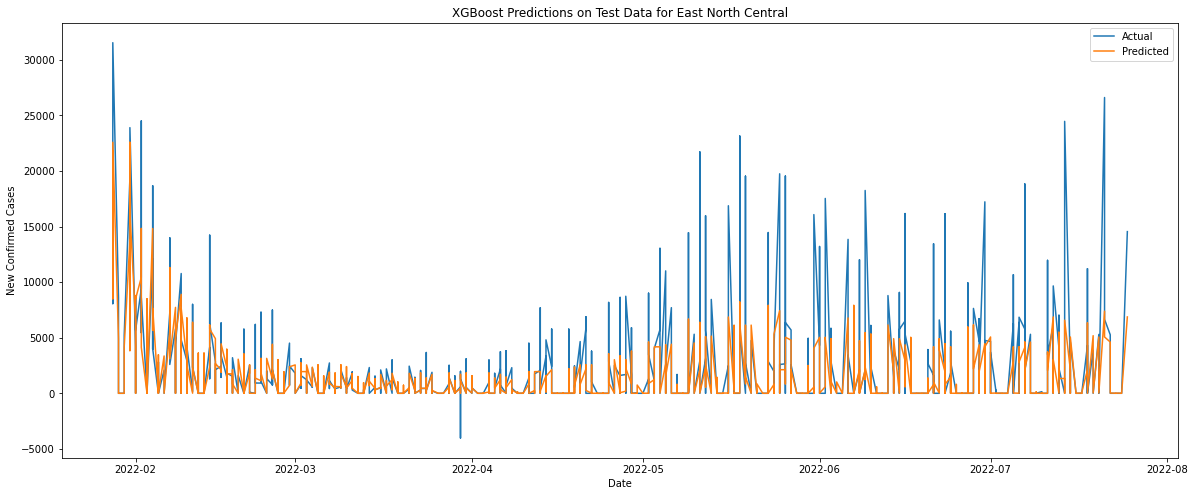

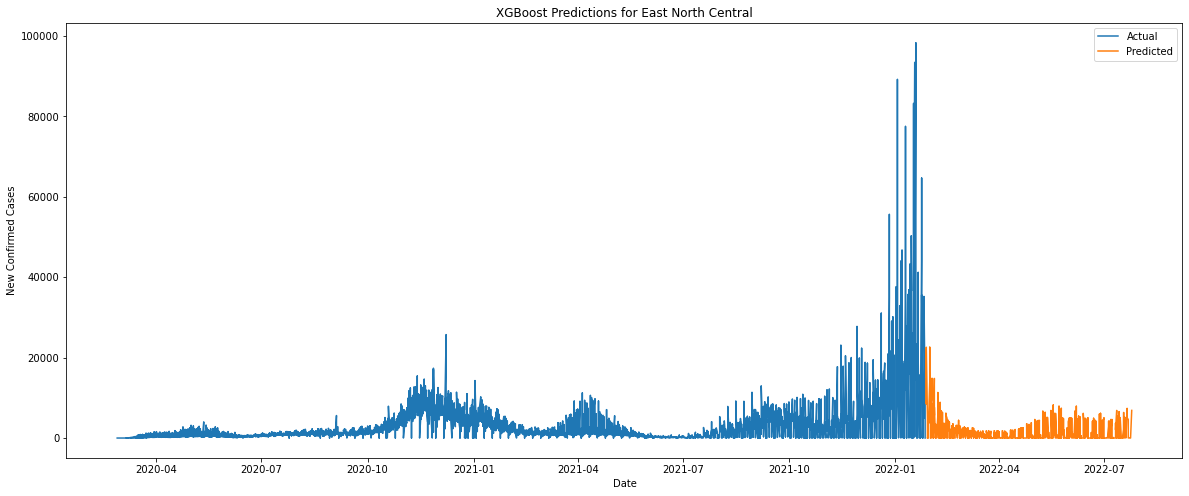


Training model for East South Central...
Model Params: n_estimators=500, learning_rate=0.1, max_depth=4, early_stopping_rounds=10
MAE: 758.68
MSE: 3852221.18
RMSE: 1962.71
MASE: 0.56


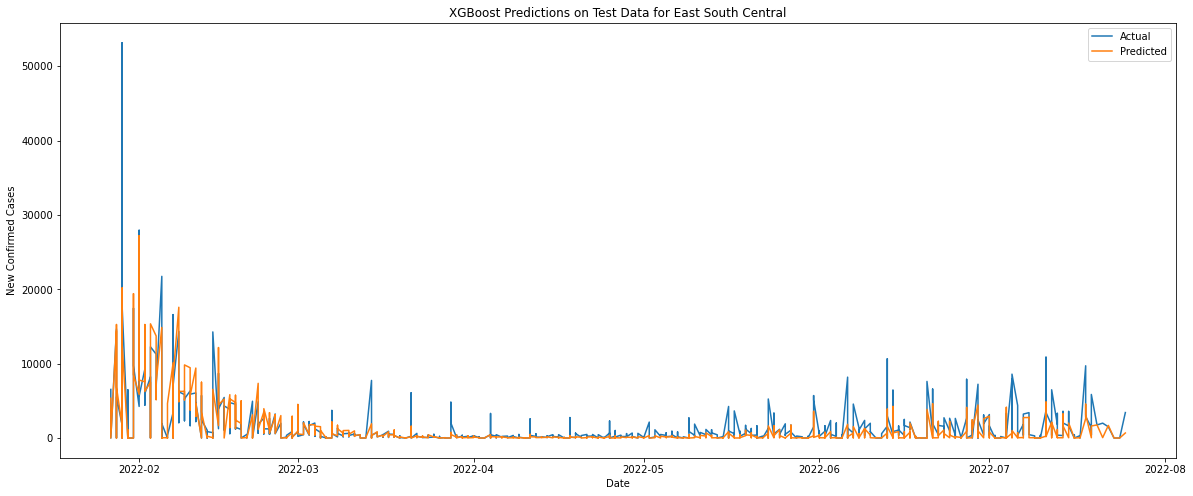

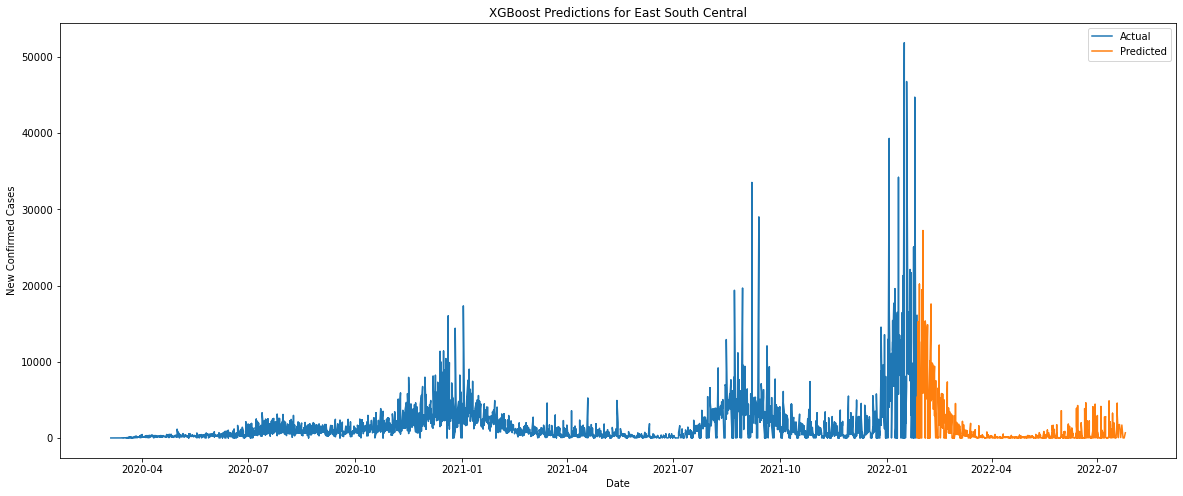


Training model for Mid-Atlantic...
Model Params: n_estimators=250, learning_rate=0.1, max_depth=3, early_stopping_rounds=10
MAE: 1585.31
MSE: 8251935.1
RMSE: 2872.62
MASE: 0.62


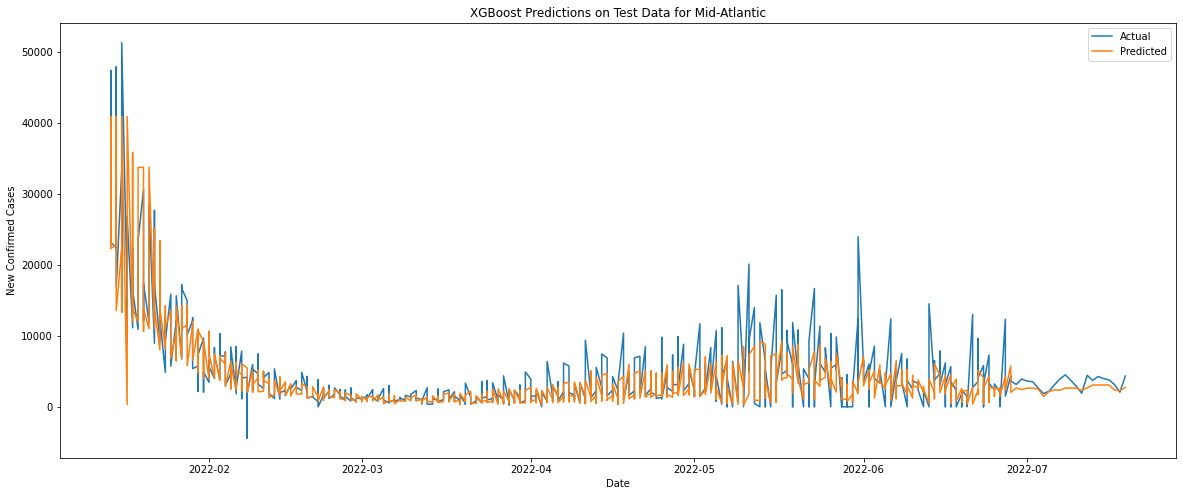

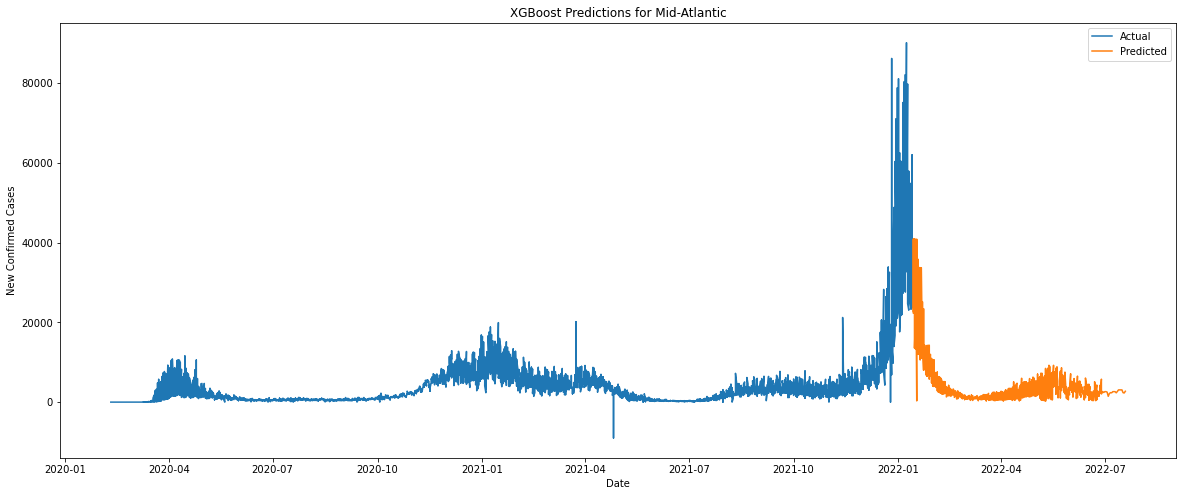


Training model for Mountain...
Model Params: n_estimators=250, learning_rate=0.05, max_depth=3, early_stopping_rounds=10
MAE: 584.05
MSE: 3028576.85
RMSE: 1740.28
MASE: 0.57


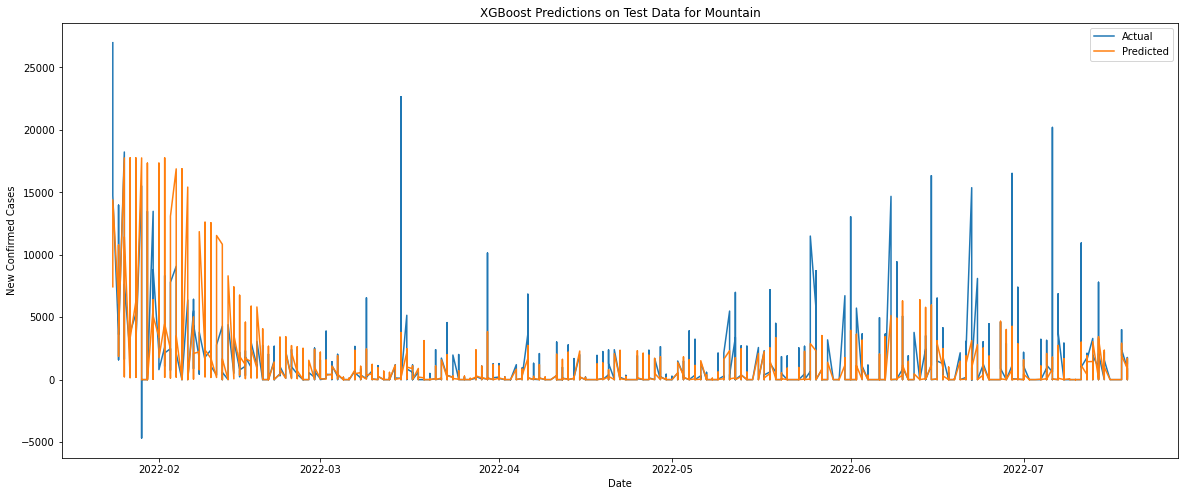

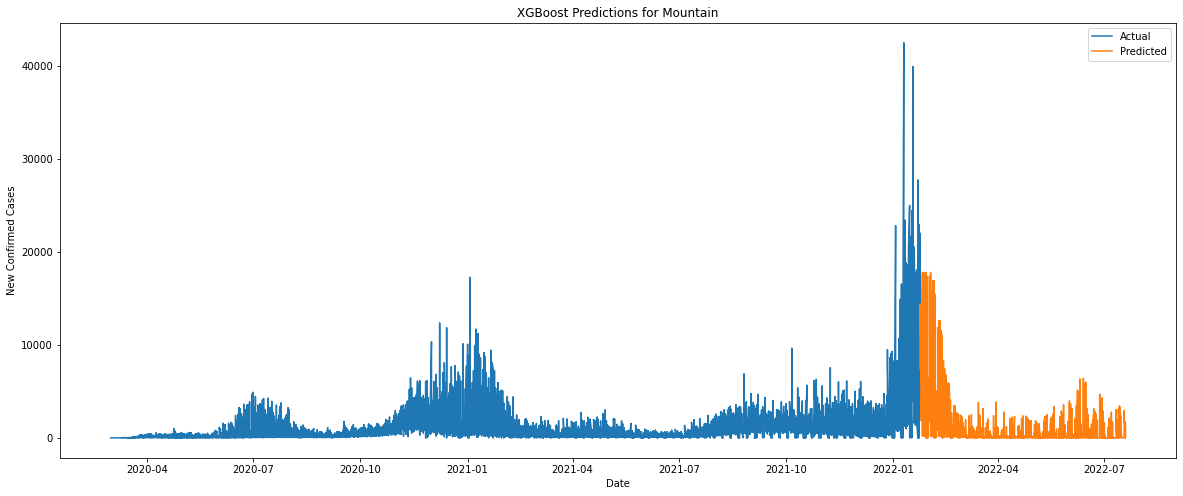


Training model for New England...
Model Params: n_estimators=1000, learning_rate=0.15, max_depth=3, early_stopping_rounds=10
MAE: 362.15
MSE: 1245607.06
RMSE: 1116.07
MASE: 0.38


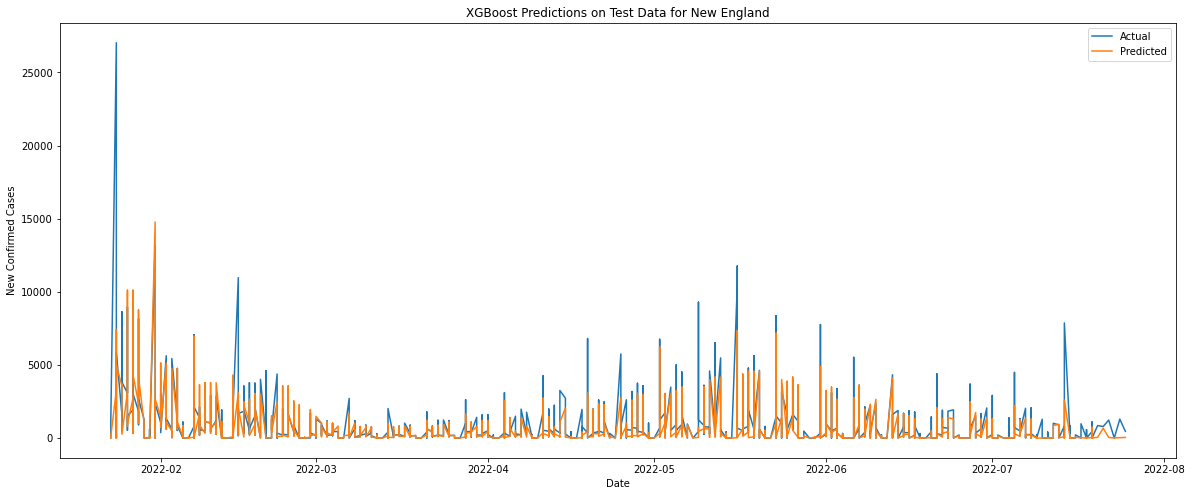

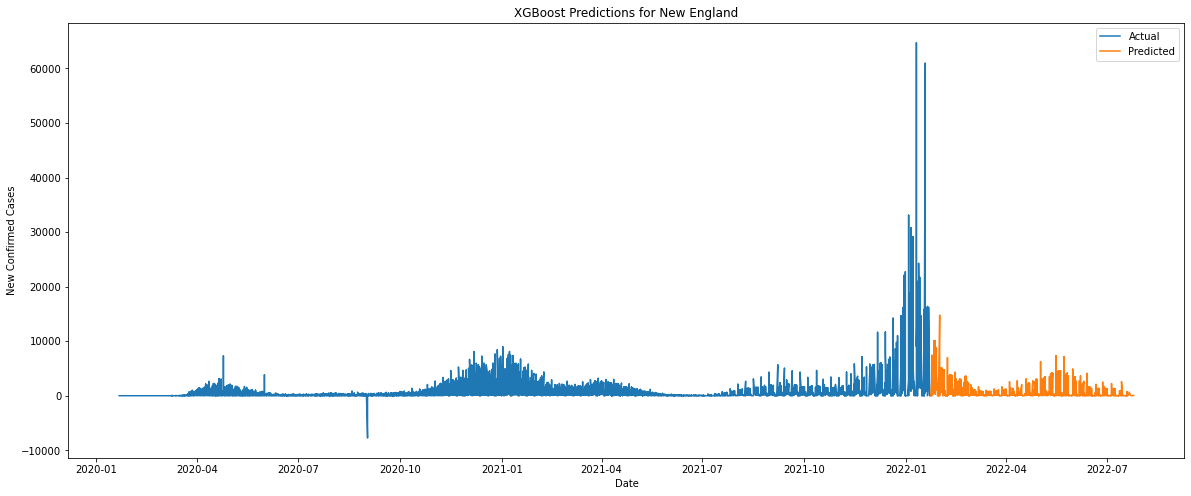


Training model for Pacific...
Model Params: n_estimators=250, learning_rate=0.05, max_depth=3, early_stopping_rounds=10
MAE: 2475.54
MSE: 52372334.11
RMSE: 7236.87
MASE: 0.54


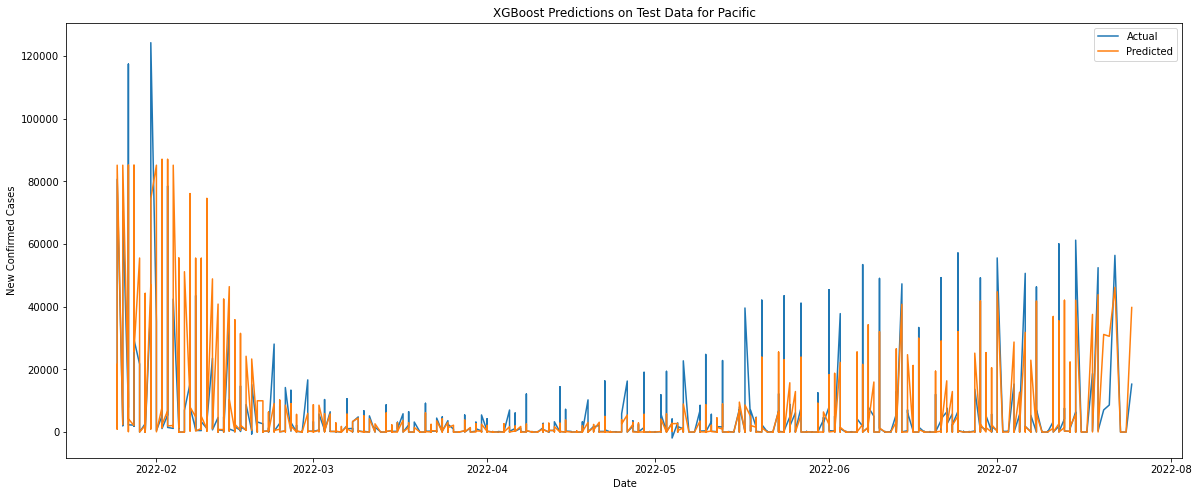

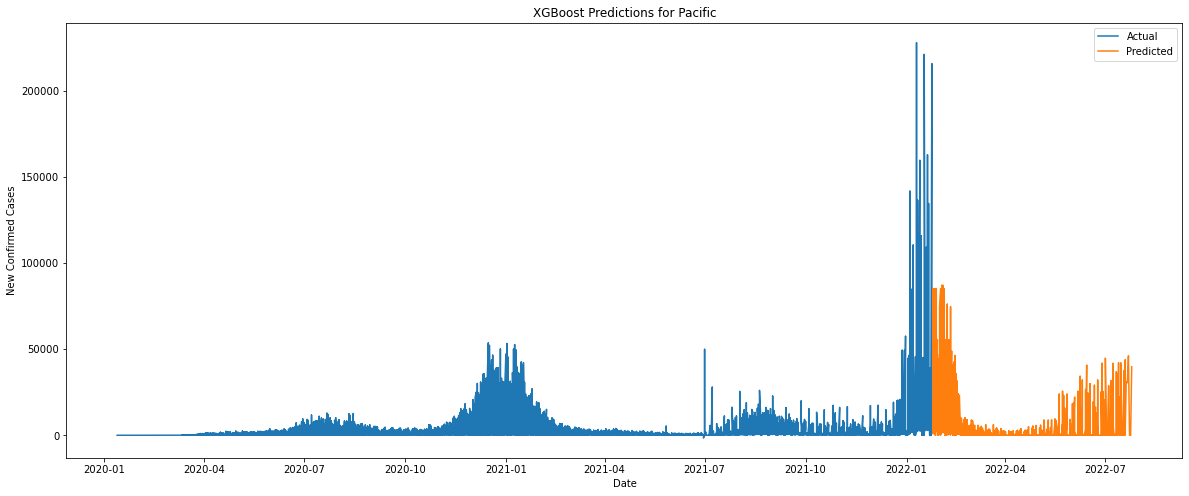


Training model for South Atlantic...
Model Params: n_estimators=500, learning_rate=0.1, max_depth=4, early_stopping_rounds=10
MAE: 1105.2
MSE: 14043604.09
RMSE: 3747.48
MASE: 0.4


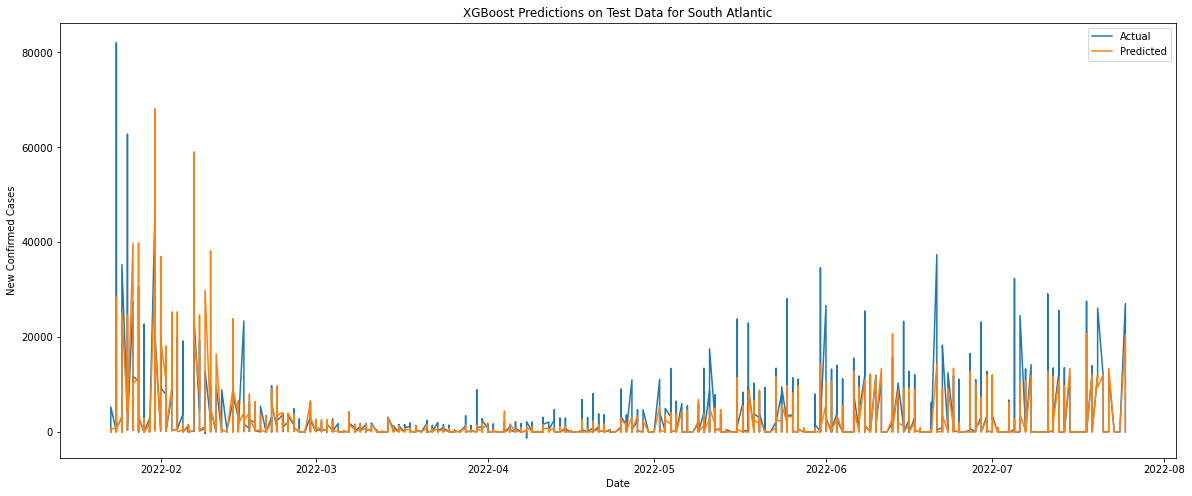

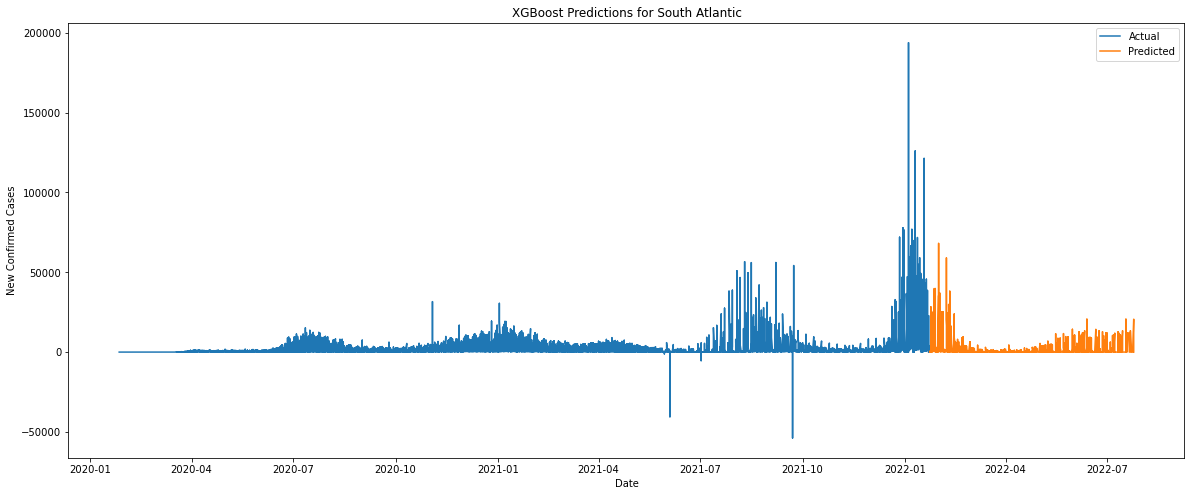


Training model for West North Central...
Model Params: n_estimators=250, learning_rate=0.1, max_depth=3, early_stopping_rounds=10
MAE: 504.28
MSE: 3063247.05
RMSE: 1750.21
MASE: 0.5


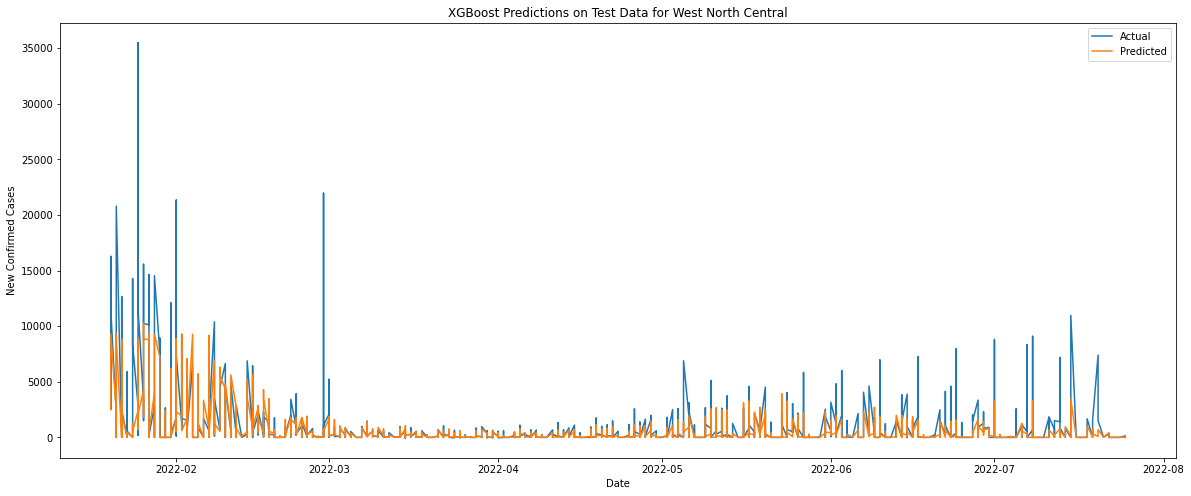

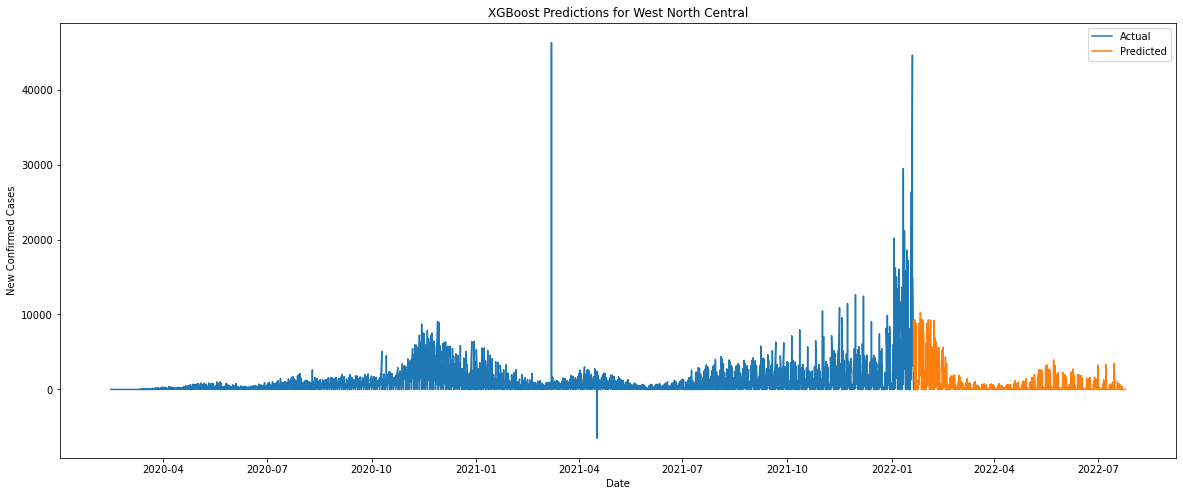


Training model for West South Central...
Model Params: n_estimators=250, learning_rate=0.05, max_depth=3, early_stopping_rounds=10
MAE: 1488.41
MSE: 18089766.91
RMSE: 4253.21
MASE: 0.36


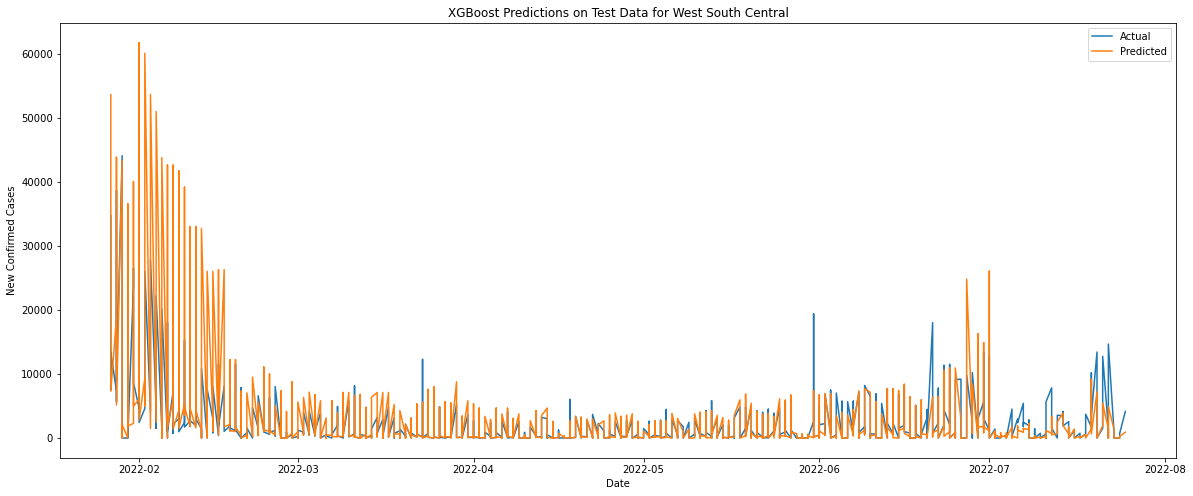

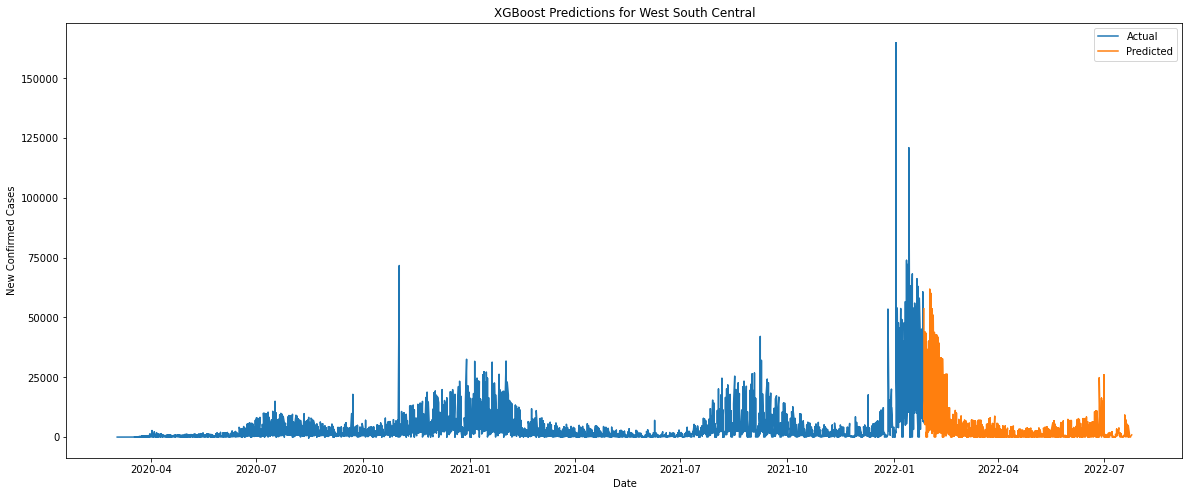


--- 9.04 seconds ---


In [175]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    params = parameters[region]
    final_model(df, params, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")